In [4]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets
from sklearn.linear_model import LinearRegression
# Warnings and logging
import warnings
import statsmodels.api as sm
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import dowhy.causal_estimators.linear_regression_estimator


## Mediation data generation
Equations are as following:
***
$ bed=p^k(1-p)^k $ <br>

$black = bed * \mathcal{N}(0.5,0.1) +\xi $<br>

$shape = bed * \mathcal{N}(0.5,0.1) + \xi$

$color = bed * \mathcal{N}(0.5,0.1) + 0.5 * shape * \mathcal{N}(0.5,0.1) + \xi$

$y = \beta_1*bed + \beta_2*shape + \beta_3*color +\xi$

we set the value of $\beta_2$ to 0

In [6]:
def generate_data(binarize=False):
    np.random.seed(1223)
    sample_size = 50
    beta1=3
    beta2=1.5
    beta3=5
    # beta4 = 1.3
    alpha1=0.01
    alpha2=0.02
    alpha3=0.005
    #binary values for bed 0 - absent, 1 - present
    bed = np.random.choice([0, 1], size=(sample_size,))
    # binary values for shape 0 - absent, 1 - present
    rect = bed * np.random.choice([0, 1], size=(sample_size,)) + np.random.normal(0.5,0.1,size=sample_size)
    # binary values for shape 0 - absent, 1 - present
    black = bed * np.random.uniform(0, 1, sample_size) + 0.5 * rect * np.random.uniform(0, 1, sample_size) +np.random.normal(0.5,0.1,size=sample_size)
    # mean of all pixel values with a high weightage of  error to account for other parameters
    # img_mean = alpha1 * bed + alpha2 * rect + alpha3 * black +  3 * np.random.normal(0.5,0.1,size=sample_size)
    y = beta1 * bed + beta3 * black + np.random.normal(0.5,0.1,size=sample_size)
    # y = np.maximum(y, 0)
    # y = [sigmoid(x) for x in y]
    df = pd.DataFrame({'obj_bed':bed,'color_black':black, 'shape_rectangle':rect, 'label_bedroom':y})
    if binarize:
        df['label_bedroom'] = (df['label_bedroom'] < df['label_bedroom'].mean() ).astype(int)
    return df

In [8]:
df = generate_data()

In [9]:
graph = nx.DiGraph()
obj = df.columns[0]
color = df.columns[1]
shape = df.columns[2]
# img_mean = df.columns[3]
# img_std = df.columns[4]
label = df.columns[3]
graph.add_edge(obj,color)
graph.add_edge(color,label)
graph.add_edge(obj,shape)
graph.add_edge(shape,color)
graph.add_edge(obj,label)
# graph.add_edge(obj,img_mean)
# graph.add_edge(obj,img_std)
# graph.add_edge(color,img_mean)
# graph.add_edge(color,img_std)
# graph.add_edge(shape,img_mean)
# graph.add_edge(shape,img_std)
# graph.add_edge(shape,img_std)
# graph.add_edge(img_mean,label)
# graph.add_edge(img_std,label)
nx.write_gml(graph, "test.gml")

In [10]:
model = CausalModel(df,
                    'shape_rectangle','label_bedroom',
                    'test.gml',
                   missing_nodes_as_confounders=True)

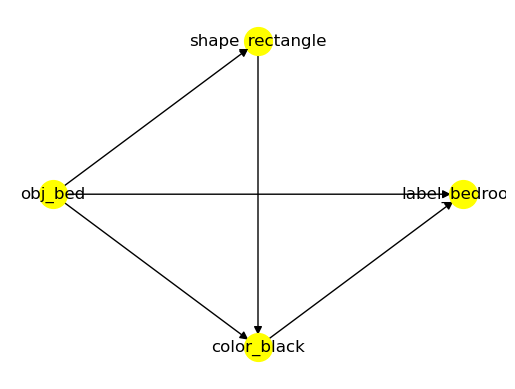

In [11]:
plt.style.use('default')
model.view_model()

In [12]:
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-nde",
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(label_bedroom|color_black, [shape_rectangle]))
Estimand assumption 1, Mediation: color_black intercepts (blocks) all directed paths from shape_rectangle to l,a,b,e,l,_,b,e,d,r,o,o,m except the path {shape_rectangle}→{l,a,b,e,l,_,b,e,d,r,o,o,m}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{shape_rectangle} and U→{color_black} then P(color_black|shape_rectangle,U) = P(color_black|shape_rectangle)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{color_black} and U→label_bedroom then P(label_bedroom|color_black, shape_rectangle, U) = P(label_bedroom|color_black, shape_rectangle)



In [13]:
identified_estimand_nie = model.identify_effect(estimand_type="nonparametric-nie",
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(label_bedroom, [color_black])*Derivative([color_black],
 [shape_rectangle]))
Estimand assumption 1, Mediation: color_black intercepts (blocks) all directed paths from shape_rectangle to l,a,b,e,l,_,b,e,d,r,o,o,m except the path {shape_rectangle}→{l,a,b,e,l,_,b,e,d,r,o,o,m}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{shape_rectangle} and U→{color_black} then P(color_black|shape_rectangle,U) = P(color_black|shape_rectangle)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{color_black} and U→label_bedroom then P(label_bedroom|color_black, shape_rectangle, U) = P(label_bedroom|color_black, shape_rectangle)



## Mediation Analysis
Once we have collected the data from running experiments with interventional set ups. We will have a lot of obervational data which is tabular in nature. Remember our design of crowd computing task promotes a mediation. So when you select an object you must select the color, when you select a shape you select color and so on. So it could be that while performing these i

We first consider two things, 
natural direct effect - effect of shape on the output given the color black = 0
natural indirect effect - effect of color on the output given shape = 0
So generally what it means is:

given, 
$\mathbb{E}[Y_{t,m}] = \mathbb{E}[Y | do(shape=t, M=m)]$

$\mathbb{E}[M_t] = \mathbb{E}[M | do(shape=t)] $

NDE = $\mathbb{E}[Y_{1,M_0} - Y_{0,M_0}]$


NIE = $\mathbb{E}[Y_{0,M_1} - Y_{0,M_0}]$

## calculating the direct effect

In [26]:
causal_estimate_nde = model.estimate_effect(identified_estimand_nde,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(label_bedroom|color_black, [shape_rectangle]))
Estimand assumption 1, Mediation: color_black intercepts (blocks) all directed paths from shape_rectangle to l,a,b,e,l,_,b,e,d,r,o,o,m except the path {shape_rectangle}→{l,a,b,e,l,_,b,e,d,r,o,o,m}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{shape_rectangle} and U→{color_black} then P(color_black|shape_rectangle,U) = P(color_black|shape_rectangle)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{color_black} and U→label_bedroom then P(label_bedroom|color_black, shape_rectangle, U) = P(label_bedroom|color_black, shape_rectangle)

## Realized estimand
(b: label_bedroom~shape_rectangle+obj_bed) - ((b: color_black~shape_rectangle+obj_bed)*(b: label_bedroom~color_black+obj_bed+shape_rectangle))
Target units: ate

## Estimate
Mean value: 0.051984593901200

## calculating the direct effect 

In [27]:
causal_estimate_nie = model.estimate_effect(identified_estimand_nie,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(label_bedroom, [color_black])*Derivative([color_black],
 [shape_rectangle]))
Estimand assumption 1, Mediation: color_black intercepts (blocks) all directed paths from shape_rectangle to l,a,b,e,l,_,b,e,d,r,o,o,m except the path {shape_rectangle}→{l,a,b,e,l,_,b,e,d,r,o,o,m}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{shape_rectangle} and U→{color_black} then P(color_black|shape_rectangle,U) = P(color_black|shape_rectangle)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{color_black} and U→label_bedroom then P(label_bedroom|color_black, shape_rectangle, U) = P(label_bedroom|color_black, shape_rectangle)

## Realized estimand
(b: color_black~shape_rectangle+obj_bed)*(b: label_bedroom~color_black+obj_bed+shape_rectangle)
Target units: ate

## Estimate
Mean value: 1.3571111054864253

